# Music21 Scale Tables

In this notebook we are developing a eye-candy presentation of scale data generated by music21 and our music21 toolchain.

## Web of Reference

### Music / Sheet Music

* [music21](http://web.mit.edu/music21/doc/moduleReference/index.html)
* [abcjs](https://github.com/paulrosen/abcjs)

### Tables

* [plim](https://plim.readthedocs.io/en/latest/syntax.html)
* [pandas]() / [style](http://pandas.pydata.org/pandas-docs/version/0.18.1/style.html)
* [d3.js](https://d3js.org/)

### Colors

* matplotlib
  * [Pyplot colormap line by line – StackOverflow](http://stackoverflow.com/questions/27443050/pyplot-colormap-line-by-line)
  * [Choosing Colormaps – Matplotlib](http://matplotlib.org/users/colormaps.html)
  * [cm (colormap)](http://matplotlib.org/api/cm_api.html)
  * [colors – Matplotlib](http://matplotlib.org/api/colors_api.html)
* [colormap (pypi)](https://pypi.python.org/pypi/colormap)
* [palettable](https://jiffyclub.github.io/palettable) / [source](https://github.com/jiffyclub/palettable)
* [pallete (pypi)](https://pypi.python.org/pypi/palette)
* [colour (pypi)](https://pypi.python.org/pypi/colour)
* [Solarized Color Scheme](http://ethanschoonover.com/solarized)
* [Seaborn](http://chrisalbon.com/python/seaborn_color_palettes.html)
* [Colour Science](http://colour-science.org/)

### Audio

* [Tone.js](https://github.com/Tonejs/Tone.js)
* [MIDI.js](https://github.com/mudcube/MIDI.js)

### Persistency

* sqlite3
* [sqlalchemy](http://docs.sqlalchemy.org/en/rel_1_1/)

### etc

* [Jupyter Magics](https://ipython.org/ipython-doc/3/interactive/magics.html)

In [15]:
from music21 import *
from IPython.display import display, HTML, Image, Audio
#import plim
import base64
#from music21.common.pathTools import relativepath as m21_jupyter_relpath
from PIL import Image as PILImage
import svgwrite as sw

In [2]:
def circleOfFifths():
    fifths = []

    fifthsScale = scale.CyclicalScale('c4', 'p5')
    
    for p in fifthsScale.getPitches('c4', 'c11'):
        
        if key.pitchToSharps(p,'major') <= 7:
            MAJOR = str(p.simplifyEnharmonic().name)
            MINOR = str(key.Key(MAJOR, 'major').relative.tonic.simplifyEnharmonic().name).lower()

        else:
            MAJOR = str(p.getEnharmonic().simplifyEnharmonic().name)
            MINOR = str(key.Key(MAJOR, 'major').relative.tonic.simplifyEnharmonic().name).lower()
        
        fifths.append( [ MAJOR, MINOR ] )

        #fifths.append(p.simplifyEnharmonic())
        
    return fifths

## The returnScale() function

This function returns a `dict()` with the data and filename of our generated scale.

In [3]:
def returnScale(tonic='c', mode='major', ownKey=False):
    
    modes = [ 'ionian','dorian','phrygian',
              'lydian','mixolydian','aeolian',
              'locrian','major','minor']
    
    if not mode in modes: mode = 'major'
        
    if mode == 'ionian': mode = 'major'
    if mode == 'aeolian': mode = 'minor'

    tonic_pitch = pitch.Pitch(tonic)
    scale_sharps = key.pitchToSharps(tonic_pitch, mode)

    scale_func = getattr(scale, "{0}Scale".format(mode.capitalize()))
    real_scale = scale_func(tonic_pitch)
    pitches = real_scale.getPitches()

    scale_name = real_scale.name
    absolute_intervals = []
    relative_intervals = []
    myKeySig = key.KeySignature(scale_sharps)
    
    mystream = stream.Stream()
    
    if ownKey:
        mystream.append(myKeySig)

    for cur_pitch in pitches:
        mynote = note.Note(cur_pitch)

        cur_degree = real_scale.getScaleDegreeFromPitch(cur_pitch)
        past_degree_or_tonic = cur_degree-1 if cur_degree>1 else 1
        
        absolute_interval = real_scale.intervalBetweenDegrees(1,cur_degree).name
        relative_interval = real_scale.intervalBetweenDegrees(past_degree_or_tonic, cur_degree).name
        
        absolute_intervals.append(absolute_interval)
        relative_intervals.append(relative_interval)
        
        mynote.addLyric(absolute_interval)
        mynote.addLyric(relative_interval)
        
        mystream.append(mynote)
        
    filename = mystream.write()
        
    return {
        'scalename': scale_name,
        'stream' : mystream,
        'filename': filename,
        'ai' : absolute_intervals,
        'ri' : relative_intervals
    }

## Creating an Array with scale data

Here we create a bidimensional array with our scale data—a list of lists.

In [4]:
#my_data = returnScale(scale_data)
def generate_table_array(scale_data):
    
    # lets embed the image
    with open(scale_data['filename'],'rb') as image_file:
        b64_image_data = base64.b64encode(image_file.read()).decode('utf8')

    imgtag  = "<img src='data:image/png;charset=utf-8;base64,{}' />".format(b64_image_data)

    my_table_data = [
        [ [scale_data['scalename'],''] ],
        [ [imgtag,'style="padding:0;"'] ],
        scale_data['ai'], # these are already lists
        scale_data['ri']
        ]
    return my_table_data

#array = [
#    [ (data, cell attributes) ]
#]

## Converting the data array to HTML

Here we use python `plim` library to help us convert the data array to a HTML table, the which we can then present on the Jupyter Notebook.

In [5]:
def array_to_htmltable(data):
    t2_slim = """
table style='float: left;'
"""

    for row in data:
        t2_slim += "\ttr\n"
        for column in row:
            
            if type(column) == list and len(column)>1:
                attrs = column[1]
            else: attrs = '';
                
            if type(column) == list:
                column = column[0]
                
            if len(row) == 1:
                t2_slim += "\t\tcaption {0} {1}\n".format(attrs, str(column))
            else:
                t2_slim += "\t\ttd {0} {1}\n".format(attrs, str(column))

    return plim.preprocessor(t2_slim)

## Displaying the table

Then we can show the IPython.display to show the HTML table.

In [6]:
Fifths = circleOfFifths()

Fifths

[['C', 'a'],
 ['G', 'e'],
 ['D', 'b'],
 ['A', 'f#'],
 ['E', 'c#'],
 ['B', 'g#'],
 ['F#', 'd#'],
 ['C#', 'a#'],
 ['A-', 'f'],
 ['E-', 'c'],
 ['B-', 'g'],
 ['F', 'd'],
 ['C', 'a']]

In [7]:
returnScale('c','mixolydian')

{'ai': ['P1', 'M2', 'M3', 'P4', 'P5', 'M6', 'm7', 'P1'],
 'filename': '/home/iacchus/git-stuff/jupyter-venv/scratchdir/tmp_li2sepi.ly.png',
 'ri': ['P1', 'M2', 'M2', 'm2', 'M2', 'M2', 'm2', 'P1'],
 'scalename': 'C mixolydian',
 'stream': <music21.stream.Stream 0x7fb7c2f455c0>}

In [8]:
# http://web.mit.edu/music21/doc/moduleReference/moduleScale.html#music21.scale.ConcreteScale.pitchesFromScaleDegrees

In [9]:
sc = scale.MajorScale('b-')

In [10]:
def scale_table(tonic='c', mode='major', ownKey=False):
    scale_data = returnScale(tonic,mode)
    scale_array = generate_table_array(scale_data)
    html_table = array_to_htmltable(scale_array)
    
    return html_table

In [11]:
HTML(scale_table('d','mixolydian',True))

P1,M2,M3,P4,P5,M6,m7,P1
P1,M2,M2,m2,M2,M2,m2,P1


In [12]:
sc = returnScale()

sc

{'ai': ['P1', 'M2', 'M3', 'P4', 'P5', 'M6', 'M7', 'P1'],
 'filename': '/home/iacchus/git-stuff/jupyter-venv/scratchdir/tmp8dwgn5ge.ly.png',
 'ri': ['P1', 'M2', 'M2', 'm2', 'M2', 'M2', 'M2', 'P1'],
 'scalename': 'C major',
 'stream': <music21.stream.Stream 0x7fb7c2ed9f98>}

<svg baseProfile="full" font-family="Inconsolata, monospace" height="216.0" version="1.1" width="302" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><rect fill="#99a" height="216.0" stroke="#666" stroke-width="1" width="302" x="0" y="0" /><g><rect color="#fff" fill="#336" height="36.0" stroke="#000" stroke-width="1" width="302" x="0" y="0" /><text alignment-baseline="middle" fill="#fff" font-weight="bold" text-anchor="middle" x="151.0" y="18.0">C major</text></g><image height="108" width="302" x="0" xlink:href="" y="36.0" /><g><rect fill="#fff" height="36.0" stroke="#666" stroke-width="1" width="37.75" x="0.0" y="144.0" /><text alignment-baseline="middle" font-weight="bold" text-anchor="middle" x="18.875" y="162.0">P1</text></g><g><rect fill="#fff" height="36.0" stroke="#666" stroke-width="1" width="37.75" x="37.75" y="144.0" /><text alignment-baseline="middle" font-weight="bold" text-anchor="middle" x=
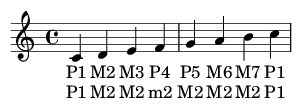


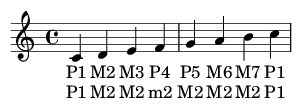

In [37]:
def svg_table(sc):

img_w, img_h = PILImage.open(sc['filename']).size

with open(sc['filename'],'rb') as image_file:
    b64_scale = base64.b64encode(image_file.read()).decode('utf8')
    image_data = "data:image/png;base64,{}".format(b64_scale)
    
def y_by_line(line_num, line_height):
    return (line_num-1) * line_height

svg_attrs = {
    'font-family': 'Inconsolata, monospace',
#    'shape-rendering':'optimizeQuality',

}

title_text_attrs = {
    'fill':'#fff',
    #'stroke':'#333',
    #'stroke-width':'1',
    #'color' : '#fff',
    'alignment-baseline' : 'middle',
    'text-anchor' : 'middle',
    'font-weight' : 'bold',
}

image_attrs = {
    'stroke' : '#666',
}

background_attrs = {
    'stroke':'#666',
    'fill':'#99a',
    'stroke-width':'1',
}

title_attrs = {
    'color': '#fff',
    'fill':'#336',
    'stroke':'#000',
    'stroke-width':'1',
}

cell_rect_attrs = {
    'fill':'#fff',
    'stroke':'#666',
    'stroke-width':'1',
}
cell_text_attrs = {
    #'fill':'#fff',
    #'stroke':'#333',
    #'stroke-width':'1',
    'alignment-baseline' : 'middle',
    'text-anchor' : 'middle',
    'font-weight' : 'bold',
}
# sizes in px

#line_height = 32

#table_width = 440
table_width = img_w
line_height = img_h/3

table_height = line_height*6

cell_width = table_width/8

# SVG

dwg = sw.Drawing(profile='full', size=("{}".format(table_width),"{}".format(table_height)), **svg_attrs)

# BACKGROUND

# why not beutiful background right now;
background = sw.shapes.Rect(insert=(0,0), size=(table_width, table_height), **background_attrs)
dwg.add(background)

# TItLE

#table_title = sw.shapes.Rect(insert=(0,0), size=(table_width, line_height), **title_attrs)
#dwg.add(table_title)

cell_group = sw.container.Group()

group_els = [
    sw.shapes.Rect(insert=(0,0), size=(table_width, line_height), **title_attrs),
    sw.text.Text(sc['scalename'], insert=(table_width/2, line_height/2), **title_text_attrs)
]

for element in group_els:
    cell_group.add(element)

dwg.add(cell_group)

# IMAGE

table_image = sw.image.Image(href=image_data, insert=(0,line_height), size=(img_w, img_h))
dwg.add(table_image)
#array = [1,2,3,4,5,6,7,8]
#array2 = ["I","II","III","IV","V","VI","VII","VIII"]

# ABSOLUTE

for idx,item in enumerate(sc['ai']):
    
    x = idx * cell_width
    y = y_by_line(line_num=5, line_height=line_height)
    
    v_center = (line_height/2) + y
    h_center = (cell_width/2) + x
    
    cell_group = sw.container.Group()
    
    group_els = [
        sw.shapes.Rect(insert=(x, y), size=(cell_width, line_height), **cell_rect_attrs),
        sw.text.Text(item, insert=(h_center, v_center), **cell_text_attrs)
    ]
    
    for element in group_els:
        cell_group.add(element)
        
    dwg.add(cell_group)
    
# RELATIVE

for idx,item in enumerate(sc['ri']):
    x = idx * cell_width
    y = y_by_line(line_num=6, line_height=line_height)

    v_center = (line_height/2) + y
    h_center = (cell_width/2) + x
    
    cell_group = sw.container.Group()
    
    group_els = [
        sw.shapes.Rect(insert=(x, y), size=(cell_width, line_height), **cell_rect_attrs),
        sw.text.Text(item, insert=(h_center, v_center), **cell_text_attrs)
    ]
    
    for element in group_els:
        cell_group.add(element)
        
    dwg.add(cell_group)

svg_data = dwg.tostring()

print(svg_data)

HTML(svg_data)